In [1]:
%load_ext autoreload
%autoreload 2

# Buddingtonite - ANU

This notebook contains the analysis for buddingtonite measured at the JEOL probe at ANU.

## Fit WD scans

In [2]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, "..")

In [3]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from nb_helper_funs import compile_n_summary

In [4]:
# ------#### INPUT #### -----------------------------
# Where is the data stored?
scan_path = Path('../data/raw/buddingtonite_ANU/raw_wd_scans')
# What's the sample name?
sample = 'buddingtonite'
# Option to add peak position markers to plot:
# e.g. pk_pos_markers = False (no markers)
#      pk_pos_markers = [145.839] (one marker)
#      pk_pos_markers = [145.84, 145.73] (two markers)
pk_pos_markers =  [145.839] #
# ---------------------------------------------------

Figure not saved


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Bud_1'}, xlabel='L (mm)', ylabel='cps/nA'>)

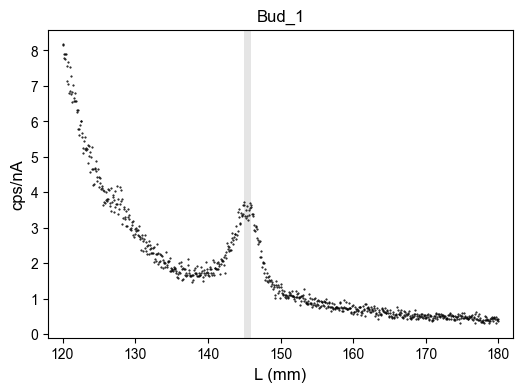

In [5]:
# Read in the data
comments, data = readfiles.import_jeol_wdscans(scan_path)

# Plot the data without fitting
wdscan.plot_wdscan(comments, data, save_to=None)

Figure not saved
Saved fit parameters for buddingtonite


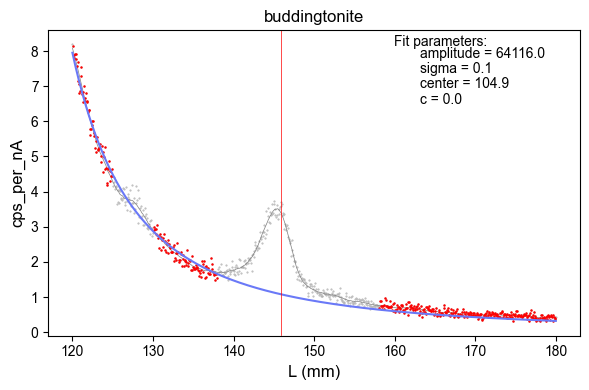

In [6]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,125], [130,138], [158,180]]

trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, pk_pos_markers, save_to=None)
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/buddingtonite_ANU/fits/"))

# Correct quantitative analyses

In [7]:
samples = ['buddingtonite'] # List of samples in this dataset
sample_folders = [Path('../data/raw/buddingtonite_ANU/raw_quant/')] # List of folders corresponding to the samples
category = 'buddingtonite' # Category of this dataset (e.g. "glasses")

wd_scan = Path('../data/interim/buddingtonite_ANU/fits/key_params_buddingtonite.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('../data/_dictionaries/standards.csv')

In [8]:
datalist = readfiles.find_files_and_folders(
                samples, sample_folders,
                apf_file=Path('../data/_dictionaries/apf_values.csv'), #<- Can put None in here
                wd_scan=wd_scan)

datalist

Comments found: ['budd-01', 'budd-02', 'budd-03', 'budd-04', 'budd-05']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\buddingtonite_ANU\raw_quant\Pos_0001,budd-01,buddingtonite,..\data\interim\buddingtonite_ANU\fits\key_par...,0.819,0.013
1,..\data\raw\buddingtonite_ANU\raw_quant\Pos_0002,budd-02,buddingtonite,..\data\interim\buddingtonite_ANU\fits\key_par...,0.819,0.013
2,..\data\raw\buddingtonite_ANU\raw_quant\Pos_0003,budd-03,buddingtonite,..\data\interim\buddingtonite_ANU\fits\key_par...,0.819,0.013
3,..\data\raw\buddingtonite_ANU\raw_quant\Pos_0004,budd-04,buddingtonite,..\data\interim\buddingtonite_ANU\fits\key_par...,0.819,0.013
4,..\data\raw\buddingtonite_ANU\raw_quant\Pos_0005,budd-05,buddingtonite,..\data\interim\buddingtonite_ANU\fits\key_par...,0.819,0.013


In [9]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
    myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()


 loading path: ..\data\interim\buddingtonite_ANU\fits\key_params_buddingtonite.txt
{'sigma': 0.08879996819573788, 'center': 104.90201398437424}
Read dataset: 1 of 5 : budd-01

 loading path: ..\data\interim\buddingtonite_ANU\fits\key_params_buddingtonite.txt
{'sigma': 0.08879996819573788, 'center': 104.90201398437424}
Read dataset: 2 of 5 : budd-02

 loading path: ..\data\interim\buddingtonite_ANU\fits\key_params_buddingtonite.txt
{'sigma': 0.08879996819573788, 'center': 104.90201398437424}
Read dataset: 3 of 5 : budd-03

 loading path: ..\data\interim\buddingtonite_ANU\fits\key_params_buddingtonite.txt
{'sigma': 0.08879996819573788, 'center': 104.90201398437424}
Read dataset: 4 of 5 : budd-04

 loading path: ..\data\interim\buddingtonite_ANU\fits\key_params_buddingtonite.txt
{'sigma': 0.08879996819573788, 'center': 104.90201398437424}
Read dataset: 5 of 5 : budd-05


In [10]:
correct_quant.process_datasets(myspot, datalist, num_mc_sims=100, path_out=Path("../data/processed/buddingtonite_ANU/background_corrections/"))


Processing dataset: 1 of 5 : budd-01
Correcting background
Saved bg correction figure for 2019-04-05_budd-01
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2019-04-05_budd-01
correct height/area ratio
original kraw: 25.88 ± 3.43%
corrected kraw: 32.50 ± 3.94%

Processing dataset: 2 of 5 : budd-02
Correcting background
Saved bg correction figure for 2019-04-05_budd-02
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarlo bg correction figure for 2019-04-05_budd-02
correct height/area ratio
original kraw: 27.09 ± 3.35%
corrected kraw: 33.85 ± 3.55%

Processing dataset: 3 of 5 : budd-03
Correcting background
Saved bg correction figure for 2019-04-05_budd-03
Resample cps to check stdev method
Montecarlo background correction
monte-carlo loop 0 of 100
monte-carlo loop 50 of 100
Saved montecarl

In [11]:
summary_tables = correct_quant.write_summary_excel_tables(myspot, "../data/processed/buddingtonite_ANU/kraw_summaries.xlsx")

In [12]:
# Write the spot objects out to a pickle file:
with open('../data/interim/buddingtonite_ANU/buddingtonite.pickle', 'wb') as handle:
    pickle.dump(myspot, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Write a spots summary table as an excel file:
info_spots = []
for spot in myspot:
    info_spots.append(spot.info)

info = pd.DataFrame(info_spots)
info.to_csv('spots_info_' + category + '.csv')

print('-----Finished-----')

-----Finished-----


# Write calczaf file

In [13]:
# Load data from the saved pickle file ---------------------------
saved_pickle_file = "../data/interim/buddingtonite_ANU/buddingtonite.pickle"
samples = ['buddingtonite']
category = 'buddingtonite'
subfolder = Path('../data/processed/buddingtonite_ANU/calczaf_files/')

write_detection_limit_calczaf_files = True
detlim_subfolder = Path('../data/processed/buddingtonite_ANU/calczaf_files/detlim/')

# note: in the subfolder there must be a file specifying valence.
# this can be copied from the _dictionaries folder.
valence_dict = readfiles.read_valence_file(subfolder, pattern='valence*')
standard_database_dict = pd.read_csv(
    '../data/_dictionaries/standards.csv',
     index_col=0, 
     header=None, 
     squeeze=True).to_dict()

standard_database_dict

{'Sanidine': 3000,
 'Diopside': 3001,
 '08_Pollucite': 3002,
 'Albite': 3003,
 'GaN': 608,
 '22_Mo': 542,
 '09_Vanadium_Wire_Alfa': 523,
 'BN': 604}

In [14]:
# Read in the data -------------------------------------------------------------
with open(saved_pickle_file, 'rb') as handle:
    myspot = pickle.load(handle)

print('Loaded data: ', [spot.info.comment for i, spot in enumerate(myspot)])

# Separate the myspot list by sample
sampledata = [None]*len(samples)
for i, sample in enumerate(samples):
    sampledata[i] = [spot for i, spot in enumerate(myspot) if sample == spot.info['sample']]

sampledata = dict(zip(samples,sampledata))

Loaded data:  ['budd-01', 'budd-02', 'budd-03', 'budd-04', 'budd-05']


In [15]:
# For multiple different methods of processing the data, add a description
run_descriptor = ['_1_base', '_2_bg', '_3_bg_apf']  
# Leave as a list of an empty string if not using: e.g. run_descriptor = ['']

for i in range(len(samples)):

    # Here we pass in these arguments as a dictionary - this is useful in order
    # to reuse the arguments for the detection limit function. But you can
    # alternatively pass in each argument just by defining it in the function
    # as normal (see glasses example).

    args = {
              'elementByDifference' : None # string element symbol
            , 'elementByStoichToStoichOxygen' : None # string element symbol
            , 'stoichOxygenRatio' : 0
            # for buddingtonite there is H
            # that can be defined stoichiometrically relative to N:
            , 'elementByStoichToOtherElement' : 'h'
            , 'OtherElement' : 'n'
            , 'stoichElementRatio' : 4

            , 'correct_bg' : False
            , 'correct_apf' : False

            # Elements to omit from matrix correction
            # (e.g. if analysed but not actually present in sample)
            , 'remove_elements' : ['Rb','Mo','Ca','Mg']

            , 'definedElements' : None # list of element symbols to add
            , 'definedElementWts' : None # list of known element wt% to add
            }
    
    # Make copies of args with different values
    args2 = args.copy()
    args2["correct_bg"] = True
    args2["correct_apf"] = False

    args3 = args2.copy()
    args3["correct_bg"] = True
    args3["correct_apf"] = True

    args_list = [args, args2, args3]

    for j in range(len(run_descriptor)):
        print("******************************************************")
        print(args_list[j]["correct_bg"], args_list[j]["correct_apf"])
        print("******************************************************")

        calczaf_path_out = subfolder / '{}{}.dat'.format(
                                            samples[i], run_descriptor[j])
        open(calczaf_path_out, 'w').close()  # Erase contents of file

        if write_detection_limit_calczaf_files:
            
            detlim_path_out = detlim_subfolder / '{}{}_detlim.dat'.format(
                                            samples[i], run_descriptor[j])
            open(detlim_path_out, 'w').close()  # Erase contents of file

        for spot in sampledata[samples[i]]:

            calczaf.write_calczaf_input(
                spot, calczaf_path_out, valence_dict, standard_database_dict,
                accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                **args_list[j]) # <- **args unpacks the args dictionary defined earlier
                # so that all those arguments are passed into the function
                # without the need to type them all out.

            if write_detection_limit_calczaf_files:
                if args_list[j]['correct_bg']:

                    detlim_spot = correct_quant.create_detection_limit_spot(spot)

                    calczaf.write_calczaf_input(
                        detlim_spot, detlim_path_out, valence_dict, 
                        standard_database_dict,
                        accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                        **args_list[j])
                    
                else:
                    print('\n\nWarning: Not writing detection limit file.' 
                            'Calculating detection limit does not make sense'
                            ' except on background-corrected data. Raw data files' 
                            ' contain an estimate of detection limit without bg'
                            ' correction.\n')
                    
    

******************************************************
False False
******************************************************
Wrote CALCZAF file for budd-01 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_1_base.dat



Wrote CALCZAF file for budd-02 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_1_base.dat



Wrote CALCZAF file for budd-03 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_1_base.dat



Wrote CALCZAF file for budd-04 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_1_base.dat



Wrote CALCZAF file for budd-05 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_1_base.dat



******************************************************
True False
******************************************************
Wrote CALCZAF file for budd-01 to ..\data\processed\buddingtonite_ANU\calczaf_files\buddingtonite_2_bg.dat
calculating a new k-raw
instead of net_cps = 111.78712938449668, using 3sd on bg = 0.96023

# Manual step - run the file through calczaf

* Using XPP matrix correction method
* Default MAC table (LINEMU)

# Process calczaf outputs

In [29]:
from src import calczaf, helper_funs
from pathlib import Path

folderpath = Path('../data/processed/buddingtonite_ANU/calczaf_files/')

helper_funs.check_calczaf_folder_exists(folderpath)
valence_file = sorted(folderpath.glob('valence*'))[0]

results = calczaf.process_calczaf_outputs(folderpath, valence_file)

# For detection limits

results_detlim = calczaf.process_calczaf_outputs(folderpath / 'detlim/', valence_file, detlim=True)

[                     0          1          2          3          4
wt% element                                                       
Si           33.242400  32.975600  32.652300  32.752100  32.964300
Al           10.147800  10.265500  10.242300  10.250400  10.129600
K             0.025358   0.037020   0.011086   0.027744   0.027228
Na            0.067019   0.127568   0.092790   0.106026   0.074863
H             1.259230   1.315570   1.214180   1.176460   1.195990
N             4.374500   4.570230   4.218030   4.086970   4.154820
O            49.428200  49.364200  48.756600  48.810700  48.972900
TOTAL        98.544500  98.655800  97.187300  97.210400  97.519700, None, None]
[                     0          1          2          3          4
wt% element                                                       
Si           33.242400  32.975600  32.652300  32.752100  32.964300
Al           10.147800  10.265500  10.242300  10.250400  10.129600
K             0.025358   0.037020   0.011086   

In [30]:
dict(
    original_raw_cps = np.mean([s.peak.loc[8, "raw_cps"] for s in myspot]),
    linear_bg_net_cps = np.mean([s.peak.loc[8, "net_cps"] for s in myspot]),
    curved_bg_net_cps = np.mean([s.corrected.loc[8, "net_cps"] for s in myspot]),
)

{'original_raw_cps': 132.9022222222222,
 'linear_bg_net_cps': 106.2,
 'curved_bg_net_cps': 109.44029352950824}

In [31]:
dict(
    linear_bg_kraw = np.mean([s.peak.loc[8, "kraw_pcnt"] for s in myspot]),
    curved_bg_kraw = np.mean([s.corrected.loc[8, "kraw_pcnt"] for s in myspot]),
    curved_bg_apf_kraw = np.mean([s.montecarlo.loc[8, "kraw_apf_pcnt"] for s in myspot])
)

{'linear_bg_kraw': 25.3154,
 'curved_bg_kraw': 26.082852957724448,
 'curved_bg_apf_kraw': 31.77967339743007}

In [32]:
wt_pct_summary_table = pd.concat(
    {k: v[["average", "stdev"]] for k, v in results["wtdata"].items()},
    axis=1
    ).round(2)

wt_pct_summary_table.to_csv("../data/processed/buddingtonite_ANU/wt_pct_summary.csv")

wt_pct_summary_table


buddingtonite_1_base       buddingtonite_2_bg       buddingtonite_3_bg_apf      
                         average stdev            average stdev                average stdev
wt% element                                                                                 
Si                         32.92  0.23              32.94  0.23                  33.10  0.24
Al                         10.21  0.06              10.21  0.06                  10.27  0.06
K                           0.03  0.01               0.03  0.01                   0.03  0.01
Na                          0.09  0.02               0.09  0.02                   0.09  0.02
H                           1.23  0.06               1.27  0.05                   1.53  0.06
N                           4.28  0.19               4.40  0.19                   5.33  0.23
O                          49.07  0.31              49.16  0.31                  49.93  0.33
TOTAL                      97.82  0.72              98.10  0.71                 100.27  0.79

In [33]:
results["wtdata"]["buddingtonite_3_bg_apf"][["average", "stdev"]].round(2)

,average,stdev
wt% element,,
Si,33.10,0.24
Al,10.27,0.06
K,0.03,0.01
Na,0.09,0.02
H,1.53,0.06
N,5.33,0.23
O,49.93,0.33
TOTAL,100.27,0.79


# Calculate expected N wt% based on stoichiometry

In [34]:
import periodictable

In [35]:
budd = periodictable.formula("NH4AlSi3O8") + 0.5*periodictable.formula("H2O")
display(budd)
df = pd.DataFrame([
    budd.atoms,
    dict(zip(
        budd.atoms.keys(),     
        [periodictable.nitrogen.mass,
            periodictable.hydrogen.mass,
            periodictable.aluminum.mass,
            periodictable.silicon.mass,
            periodictable.oxygen.mass
        ]
    ))
]
).T

df.columns = ["n_mols", "molar_mass"]

df
df["wt"] = df["n_mols"] * df["molar_mass"]
df["wt%"] = (df["wt"] / df["wt"].sum())*100

df

formula('NH4AlSi3O8(H2O)0.5')

,n_mols,molar_mass,wt,wt%
N,1.0,14.006700,14.006700,5.260153
H,5.0,1.007940,5.039700,1.892637
Al,1.0,26.981538,26.981538,10.132794
Si,3.0,28.085500,84.256500,31.642147
O,8.5,15.999400,135.994900,51.072269


In [36]:
budd = periodictable.formula("NH4AlSi3O8")
display(budd)
df = pd.DataFrame([
    budd.atoms,
    dict(zip(
        budd.atoms.keys(),     
        [periodictable.nitrogen.mass,
            periodictable.hydrogen.mass,
            periodictable.aluminum.mass,
            periodictable.silicon.mass,
            periodictable.oxygen.mass
        ]
    ))
]
).T

df.columns = ["n_mols", "molar_mass"]

df
df["wt"] = df["n_mols"] * df["molar_mass"]
df["wt%"] = (df["wt"] / df["wt"].sum())*100

df

formula('NH4AlSi3O8')

,n_mols,molar_mass,wt,wt%
N,1.0,14.006700,14.006700,5.444322
H,4.0,1.007940,4.031760,1.567121
Al,1.0,26.981538,26.981538,10.487566
Si,3.0,28.085500,84.256500,32.750007
O,8.0,15.999400,127.995200,49.750983


Get stdev on individual measurements

In [37]:
sampledata["buddingtonite"][0].peak

,element,pos,net_cps,stdev_net_cps,dl_ppm,kraw_pcnt,time,raw_cps,kraw_stdev_pcnt,stdev_raw_cps,kraw_apf_pcnt,kraw_stdev_apf_pcnt
0,Na,129.600,6.0,25.17,186.0,0.744,10.0,14.400000,25.181172,1.200000,0.744000,25.181172
1,Si,77.747,23831.8,0.21,109.0,124.008,10.0,23904.000000,0.246982,48.891717,124.008000,0.246982
2,Al,90.926,7385.5,0.37,37.0,99.861,10.0,7423.200000,0.425441,27.245550,99.861000,0.425441
3,Mg,107.748,2.7,86.46,64.0,0.041,10.0,28.600000,86.460306,1.691153,0.041000,86.460306
4,K,120.028,5.5,31.54,83.0,0.240,10.0,17.800000,31.544622,1.334166,0.240000,31.544622
5,Ca,107.808,6.0,31.88,102.0,0.136,10.0,21.300000,31.881230,1.459452,0.136000,31.881230
6,Rb,234.403,0.2,64.36,128.0,1.922,120.0,2.300000,64.374157,0.138444,1.922000,64.374157
7,Mo,173.162,0.5,112.94,132.0,0.008,30.0,5.050000,112.940323,0.410284,0.008000,112.940323
8,N,145.729,108.7,3.41,265.0,25.877,10.0,135.188889,3.427915,3.676804,31.595849,3.777582
9,N,145.729,43.5,10.34,381.0,10.351,5.0,98.452941,10.345922,4.437408,10.351000,10.345922


In [38]:
suffix_list = ["1_base", "2_bg", "3_bg_apf"]

summary, details = compile_n_summary(
    suffix_list, results, results_detlim, sampledata, datalist, summary_tables, samples
)

summary


Sample: buddingtonite, suffix: 1_base


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,buddingtonite,budd-01,4.37450,25.18,1.101499,NaN,0.0265
1,buddingtonite,budd-02,4.57023,13.83,0.632063,NaN,0.0267
2,buddingtonite,budd-03,4.21803,18.87,0.795942,NaN,0.0268
3,buddingtonite,budd-04,4.08697,16.83,0.687837,NaN,0.0268
4,buddingtonite,budd-05,4.15482,22.00,0.914060,NaN,0.0262


Sample: buddingtonite, suffix: 2_bg


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,buddingtonite,budd-01,4.49516,27.62,1.241563,0.040292,0.0265
1,buddingtonite,budd-02,4.67335,13.25,0.619219,0.037357,0.0267
2,buddingtonite,budd-03,4.33928,16.87,0.732037,0.039730,0.0268
3,buddingtonite,budd-04,4.22160,17.55,0.740891,0.034843,0.0268
4,buddingtonite,budd-05,4.25524,23.22,0.988067,0.036236,0.0262


Sample: buddingtonite, suffix: 3_bg_apf


,sample,comment,N,N stdev pct (individual spots),N stdev abs (individual spots),N detlim,N detlim (orig)
0,buddingtonite,budd-01,5.44499,27.62,1.503906,0.049192,0.0265
1,buddingtonite,budd-02,5.65944,13.25,0.749876,0.045610,0.0267
2,buddingtonite,budd-03,5.25693,16.87,0.886844,0.048506,0.0268
3,buddingtonite,budd-04,5.11530,17.55,0.897735,0.042540,0.0268
4,buddingtonite,budd-05,5.15585,23.22,1.197188,0.044241,0.0262


1_base                                                                                                 2_bg                                                                                              3_bg_apf                                                                                      
              N wt% (average) N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots) N wt% (average)  N detlim N detlim (orig) N stdev abs (individual spots) N stdev abs (multiple spots)
sample                                                                                                                                                                                                                                                                                                                        
buddingtonite         4.28091      NaN          0.0266                        0.82628                     0.193604        4.396926  0.037692          0.0266                       0.864355                     0.187215        5.326502  0.046018          0.0266                        1.04711                      0.22553

In [39]:
summary.to_csv("../data/processed/buddingtonite_ANU/nitrogen_summary.csv")